# Explore Fredholm-LLM Dataset

This notebook explores the Fredholm-LLM dataset containing ~500,000 Fredholm integral equations of the second kind.

**Dataset Source:** [Zenodo DOI: 10.5281/zenodo.16784707](https://doi.org/10.5281/zenodo.16784707)

**Equation form:** $u(x) - \lambda \int_a^b K(x, t) u(t) dt = f(x)$

## Contents
1. Load and inspect the dataset
2. Analyze equation statistics  
3. Explore expression types
4. Visualize data distributions
5. Display sample equations

In [13]:
# Import required libraries
import sys
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Add project root to path (handle both notebook and script execution)
notebook_dir = Path.cwd()
if notebook_dir.name == "notebooks":
    project_root = notebook_dir.parent
else:
    # Try to find project root by looking for pyproject.toml
    project_root = notebook_dir
    while project_root.parent != project_root:
        if (project_root / "pyproject.toml").exists():
            break
        project_root = project_root.parent

sys.path.insert(0, str(project_root))

# Import project modules
from src.data.fredholm_loader import FredholmDatasetLoader, ExpressionType

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

print(f"Project root: {project_root}")

Project root: c:\Users\ammah\Documents\GitHub\fred-llm


## Configuration

Set the paths to the datasets you want to explore.

In [ ]:
# Dataset paths configuration
# Change these to explore different datasets

# Original dataset - choose one:
# Option 1: Sample dataset (5,000 equations)
ORIGINAL_DATASET_PATH = "samples/Fredholm_Dataset_Sample.csv"
# Option 2: Full dataset
# ORIGINAL_DATASET_PATH = "raw/Fredholm_Dataset.csv"
# Option 3: Custom path
# ORIGINAL_DATASET_PATH = "raw/custom_dataset.csv"

# Augmented dataset path
AUGMENTED_DATASET_PATH = "processed/augmented/augmented_equations.json"
# To use a different augmented dataset:
# AUGMENTED_DATASET_PATH = "processed/augmented/custom_augmented.json"

print(f"📁 Configuration:")
print(f"  Original dataset: data/{ORIGINAL_DATASET_PATH}")
print(f"  Augmented dataset: data/{AUGMENTED_DATASET_PATH}")

## 1. Load Dataset

Load the Fredholm-LLM dataset using the specialized loader. If not downloaded yet, run:
```bash
python -m src.cli dataset download --variant sample
```

In [ ]:
# Load the dataset using configured path
data_dir = project_root / "data"
dataset_path = data_dir / ORIGINAL_DATASET_PATH

if not dataset_path.exists():
    raise FileNotFoundError(
        f"Dataset not found at: {dataset_path}\n"
        "Please run:\n"
        "  python -m src.cli dataset download --variant sample"
    )

# Load as DataFrame for exploration
df = pd.read_csv(dataset_path)
print(f"✓ Loaded dataset: {len(df):,} equations")
print(f"  Path: {dataset_path.relative_to(project_root)}")

# Also load as FredholmEquation objects
loader = FredholmDatasetLoader(data_path=dataset_path, max_samples=1000)
equations = loader.load()
print(f"\nLoaded {len(equations)} equations as FredholmEquation objects")

Loaded full dataset: 500,001 equations
Path: c:\Users\ammah\Documents\GitHub\fred-llm\data\raw\Fredholm_Dataset.csv
2025-12-26 15:38:33 | INFO     | src.data.fredholm_loader | Loading Fredholm dataset from c:\Users\ammah\Documents\GitHub\fred-llm\data\raw\Fredholm_Dataset.csv
2025-12-26 15:38:35 | INFO     | src.data.fredholm_loader | Loaded 500001 rows from CSV


Output()

2025-12-26 15:42:14 | INFO     | src.data.fredholm_loader | Loaded 1000 valid equations

Loaded 1000 equations as FredholmEquation objects


## 2. Dataset Overview

Examine the structure and basic statistics of the dataset.

In [15]:
# Dataset Schema Overview
schema_data = {
    'Column': df.columns.tolist(),
    'Type': [str(df[col].dtype) for col in df.columns],
    'Non-Null': [df[col].notna().sum() for col in df.columns],
    'Sample Value': [str(df[col].iloc[0])[:50] + '...' if len(str(df[col].iloc[0])) > 50 else str(df[col].iloc[0]) for col in df.columns]
}
schema_df = pd.DataFrame(schema_data)
display(schema_df)

# Expression length statistics
expr_stats = []
for col in ['u', 'f', 'kernel']:
    lengths = df[col].str.len()
    expr_stats.append({
        'Expression': col,
        'Min Length': lengths.min(),
        'Max Length': lengths.max(),
        'Mean Length': f"{lengths.mean():.1f}",
        'Median': lengths.median()
    })
display(pd.DataFrame(expr_stats))

,Column,Type,Non-Null,Sample Value
0,u,object,500001,x**5 - 4.5122050010253292*x
1,f,object,500001,x**5 - 4.5122050010253292*x + 666794.57509504...
2,kernel,object,500001,tanh(x)
3,lambda,float64,500001,-7.84901097234706
4,a,float64,500001,-5.799545769208079
5,b,float64,500000,9.04729673835418


,Expression,Min Length,Max Length,Mean Length,Median
0,u,1,189,21.0,18.0
1,f,2,34654,77.4,56.0
2,kernel,2,186,29.4,25.0


## 3. Expression Type Analysis

Analyze the types of mathematical expressions in the dataset (polynomial, trigonometric, hyperbolic, exponential).

,Type,u(x) Count,u(x) %,"K(x,t) Count","K(x,t) %",f(x) Count,f(x) %
0,real_value,257,25.7%,64,6.4%,54,5.4%
1,polynomial,496,49.6%,248,24.8%,190,19.0%
2,trigonometric,95,9.5%,227,22.7%,259,25.9%
3,hyperbolic,78,7.8%,266,26.6%,281,28.1%
4,exponential,74,7.4%,195,19.5%,216,21.6%


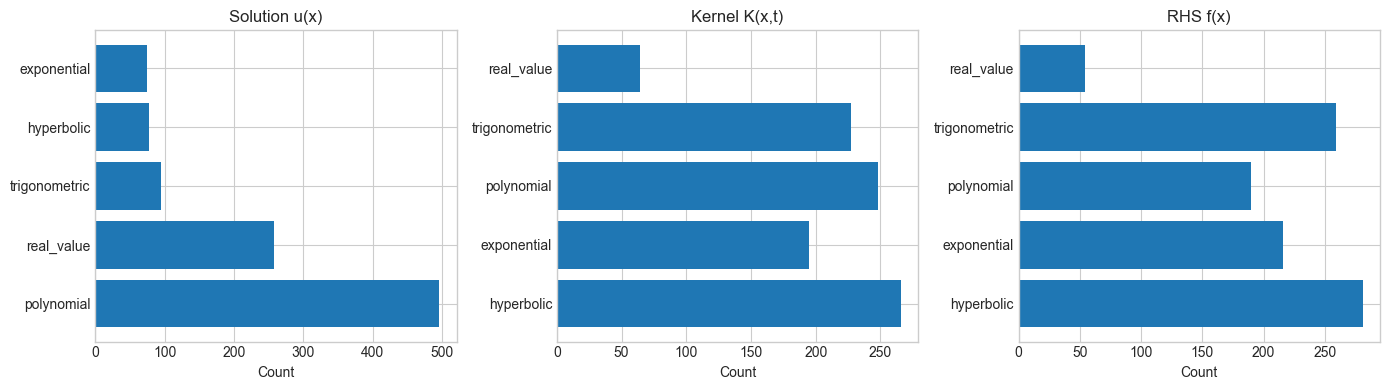

In [16]:
# Count expression types
from collections import Counter

u_types = Counter(eq.metadata.get('u_type', ExpressionType.REAL_VALUE) for eq in equations)
kernel_types = Counter(eq.metadata.get('kernel_type', ExpressionType.REAL_VALUE) for eq in equations)
f_types = Counter(eq.metadata.get('f_type', ExpressionType.REAL_VALUE) for eq in equations)

# Create summary table
total = len(equations)
type_summary = []
for expr_type in ExpressionType:
    type_summary.append({
        'Type': expr_type.value,
        'u(x) Count': u_types.get(expr_type, 0),
        'u(x) %': f"{100 * u_types.get(expr_type, 0) / total:.1f}%",
        'K(x,t) Count': kernel_types.get(expr_type, 0),
        'K(x,t) %': f"{100 * kernel_types.get(expr_type, 0) / total:.1f}%",
        'f(x) Count': f_types.get(expr_type, 0),
        'f(x) %': f"{100 * f_types.get(expr_type, 0) / total:.1f}%",
    })
display(pd.DataFrame(type_summary))

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
for ax, (title, types) in zip(axes, [('Solution u(x)', u_types), ('Kernel K(x,t)', kernel_types), ('RHS f(x)', f_types)]):
    labels = [t.value for t in types.keys()]
    ax.barh(labels, list(types.values()))
    ax.set_xlabel('Count')
    ax.set_title(title)
plt.tight_layout()
plt.show()

## 4. Numerical Parameters Distribution

Analyze the distribution of λ (lambda) parameter and integration bounds [a, b].

,Parameter,Min,Max,Mean,Std
0,λ,-10.000,10.000,-0.004,5.769
1,Lower bound (a),-10.000,9.971,-3.141,4.775
2,Upper bound (b),-9.957,10.000,3.334,4.710


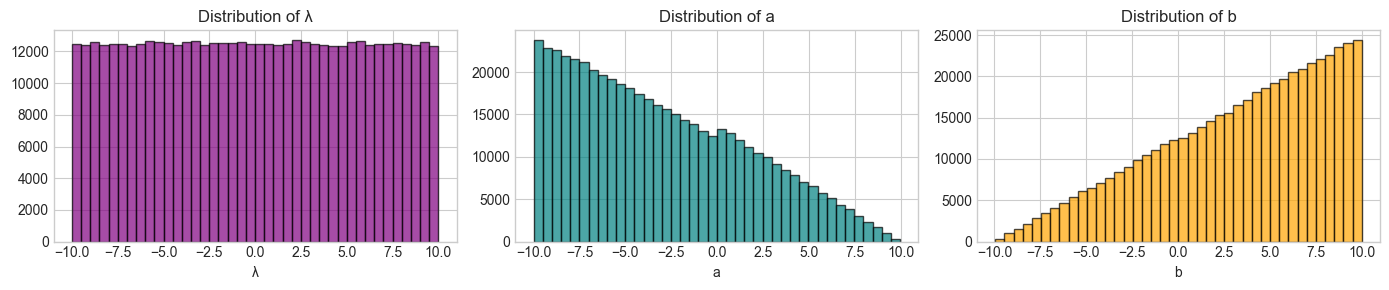

In [17]:
# Numerical parameters statistics
stats_data = []
for col, label in [('lambda', 'λ'), ('a', 'Lower bound (a)'), ('b', 'Upper bound (b)')]:
    col_data = pd.to_numeric(df[col], errors='coerce')
    stats_data.append({
        'Parameter': label,
        'Min': f"{col_data.min():.3f}",
        'Max': f"{col_data.max():.3f}",
        'Mean': f"{col_data.mean():.3f}",
        'Std': f"{col_data.std():.3f}"
    })
display(pd.DataFrame(stats_data))

# Distribution plots
fig, axes = plt.subplots(1, 3, figsize=(14, 3))
for ax, (col, label, color) in zip(axes, [('lambda', 'λ', 'purple'), ('a', 'a', 'teal'), ('b', 'b', 'orange')]):
    ax.hist(pd.to_numeric(df[col], errors='coerce').dropna(), bins=40, color=color, alpha=0.7, edgecolor='black')
    ax.set_xlabel(label)
    ax.set_title(f'Distribution of {label}')
plt.tight_layout()
plt.show()

## 5. Solution Characteristics

Analyze the types of solutions in the dataset: exact symbolic, special functions, constants, etc.

,Solution Type,Count,Percentage
0,Polynomial,134836,27.0%
1,Constant,128378,25.7%
2,Linear (x),89864,18.0%
3,Hyperbolic,46403,9.3%
4,Trigonometric,43823,8.8%
5,Exponential,39013,7.8%
6,Other Symbolic,10336,2.1%
7,Trivial (zero),4964,1.0%
8,Rational,2384,0.5%


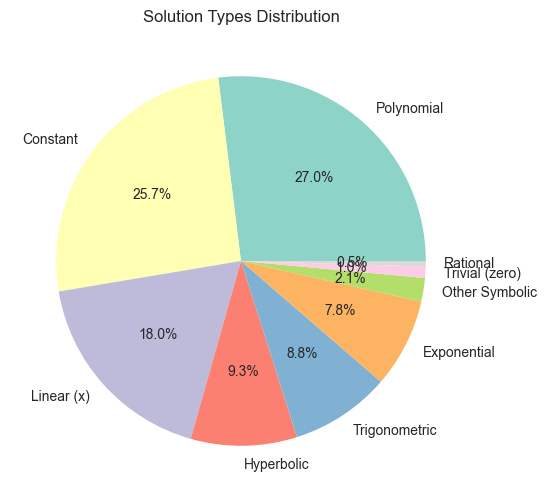

In [18]:
import re

def classify_solution(u_expr: str) -> str:
    """Classify solution type based on expression."""
    u = u_expr.strip().lower()
    
    # Check for no solution / trivial
    if u in ['0', '0.0', 'none', 'null', '']:
        return 'Trivial (zero)'
    
    # Check for constant
    if re.match(r'^-?\d+\.?\d*$', u):
        return 'Constant'
    
    # Check for simple variable
    if u in ['x', 't']:
        return 'Linear (x)'
    
    # Check for special functions
    if any(fn in u for fn in ['bessel', 'legendre', 'hermite', 'laguerre', 'gamma', 'erf']):
        return 'Special Function'
    
    # Check for exponential
    if 'exp(' in u:
        return 'Exponential'
    
    # Check for hyperbolic
    if any(fn in u for fn in ['sinh', 'cosh', 'tanh']):
        return 'Hyperbolic'
    
    # Check for trigonometric
    if any(fn in u for fn in ['sin', 'cos', 'tan']):
        return 'Trigonometric'
    
    # Check for polynomial
    if '**' in u or (re.search(r'x\s*\*', u) or re.search(r'\*\s*x', u)):
        return 'Polynomial'
    
    # Check for rational
    if '/' in u and 'x' in u:
        return 'Rational'
    
    return 'Other Symbolic'

# Classify all solutions
df['solution_type'] = df['u'].apply(classify_solution)
solution_counts = df['solution_type'].value_counts()

# Display as table
solution_table = pd.DataFrame({
    'Solution Type': solution_counts.index,
    'Count': solution_counts.values,
    'Percentage': [f"{100*c/len(df):.1f}%" for c in solution_counts.values]
})
display(solution_table)

# Pie chart
fig, ax = plt.subplots(figsize=(8, 6))
colors = plt.cm.Set3(range(len(solution_counts)))
ax.pie(solution_counts.values, labels=solution_counts.index, autopct='%1.1f%%', colors=colors)
ax.set_title('Solution Types Distribution')
plt.show()

## 6. Sample Equations

Display sample equations from each solution type in a clean format.

In [19]:
# Show sample equations from each solution type
n_samples = 3

for sol_type in df['solution_type'].unique():
    subset = df[df['solution_type'] == sol_type].head(n_samples)
    print(f"\n{'='*60}")
    print(f"Solution Type: {sol_type.upper()} ({len(df[df['solution_type'] == sol_type])} total)")
    print('='*60)
    
    for idx, row in subset.iterrows():
        print(f"\nEquation #{idx}:")
        print(f"  u(x) = {row['u']}")
        print(f"  f(x) = {row['f']}")
        print(f"  K(x,t) = {row['kernel']}")
        print(f"  λ = {row['lambda']}, a = {row['a']}, b = {row['b']}")


Solution Type: POLYNOMIAL (134836 total)

Equation #0:
  u(x) = x**5 - 4.5122050010253292*x
  f(x) =  x**5 - 4.5122050010253292*x + 666794.57509504173*tanh(x)
  K(x,t) =  tanh(x)
  λ = -7.84901097234706, a = -5.799545769208079, b = 9.04729673835418

Equation #1:
  u(x) = x**6 - x**2 - 8.322897916180308
  f(x) =  x**6 - x**2 - 71493.26069309259*exp(7*x)*exp(5.163548856594746*exp(-x)) + 85.04967327505536*exp(7*x)*exp(10.32709771318949*exp(-x)) - 85.04967327505536*exp(7*x)*exp(-11.62044705231087*exp(-x)) + 71493.26069309259*exp(7*x)*exp(-5.810223526155436*exp(-x)) + 369158.9445060483*exp(6*x)*exp(5.163548856594746*exp(-x)) - 878.3162863863377*exp(6*x)*exp(10.32709771318949*exp(-x)) - 988.3152251091198*exp(6*x)*exp(-11.62044705231087*exp(-x)) + 415391.8252405702*exp(6*x)*exp(-5.810223526155436*exp(-x)) - 953085.1229029644*exp(5*x)*exp(5.163548856594746*exp(-x)) + 4535.229056298717*exp(5*x)*exp(10.32709771318949*exp(-x)) - 5742.332372186614*exp(5*x)*exp(-11.62044705231087*exp(-x)) + 120675

## 7. Explore Augmented Datasets

Analyze augmented datasets with edge case strategies to understand the distribution of different equation types.

In [ ]:
# Load augmented dataset using configured path
import json

augmented_path = project_root / "data" / AUGMENTED_DATASET_PATH

if augmented_path.exists():
    print(f"✓ Loading augmented dataset from: {augmented_path.relative_to(project_root)}")
    with open(augmented_path, 'r', encoding='utf-8') as f:
        augmented_data = json.load(f)
    
    aug_df = pd.DataFrame(augmented_data)
    print(f"  Loaded {len(aug_df):,} augmented equations")
    print(f"  Columns: {len(aug_df.columns)} ({', '.join(list(aug_df.columns)[:5])}...)")
else:
    print(f"❌ Augmented dataset not found at: {augmented_path.relative_to(project_root)}")
    print("\nTo generate augmented data, run:")
    print("  python scripts/prepare_dataset.py --augment --augment-multiplier 1.33 --augment-strategies no_solution approximate_only ill_posed --no-convert")
    aug_df = None

Loading augmented dataset from: c:\Users\ammah\Documents\GitHub\fred-llm\data\processed\augmented\augmented_equations.json

✓ Loaded 7000 augmented equations

Columns: ['u', 'f', 'kernel', 'lambda', 'a', 'b', 'u_type', 'f_type', 'kernel_type', 'augmented', 'augmentation_type', 'has_solution', 'solution_type', 'lambda_val', 'reason', 'edge_case', 'augmentation_variant', 'numerical_method', 'sample_points', 'sample_values', 'equation_type', 'equation_form', 'is_ill_posed', 'requires_regularization', 'recommended_methods', 'warning', 'regularization_param', 'notes']


### 7.1 Augmentation Type Distribution

Analyze the distribution of original vs augmented equations and different augmentation strategies.

Augmentation Type Distribution:


,Augmentation Type,Count,Percentage
0,original,5000,71.4%
1,approximate_only,726,10.4%
2,ill_posed,723,10.3%
3,no_solution,551,7.9%



📊 Dataset Balance:
  Original equations: 5000 (71.4%)
  Augmented variants: 2000 (28.6%)


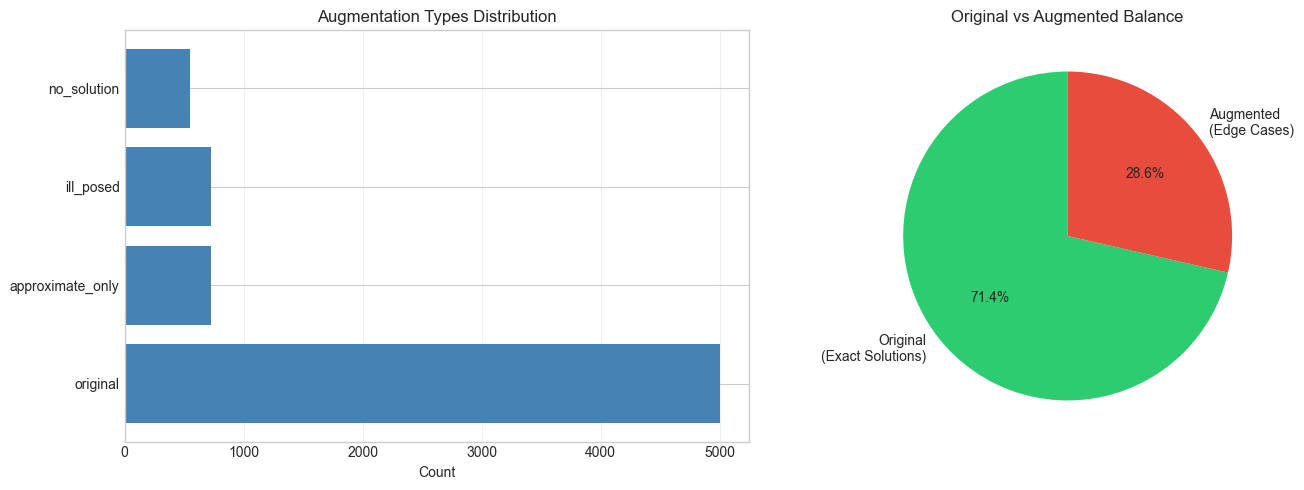

In [21]:
if aug_df is not None:
    # Count augmentation types
    aug_type_counts = aug_df['augmentation_type'].value_counts()
    
    # Create summary table
    aug_summary = pd.DataFrame({
        'Augmentation Type': aug_type_counts.index,
        'Count': aug_type_counts.values,
        'Percentage': [f"{100*c/len(aug_df):.1f}%" for c in aug_type_counts.values]
    })
    print("Augmentation Type Distribution:")
    display(aug_summary)
    
    # Calculate balance
    original_count = aug_type_counts.get('original', 0)
    augmented_count = len(aug_df) - original_count
    print(f"\n📊 Dataset Balance:")
    print(f"  Original equations: {original_count} ({100*original_count/len(aug_df):.1f}%)")
    print(f"  Augmented variants: {augmented_count} ({100*augmented_count/len(aug_df):.1f}%)")
    
    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Bar chart
    axes[0].barh(aug_type_counts.index, aug_type_counts.values, color='steelblue')
    axes[0].set_xlabel('Count')
    axes[0].set_title('Augmentation Types Distribution')
    axes[0].grid(axis='x', alpha=0.3)
    
    # Pie chart for original vs augmented
    balance_data = [original_count, augmented_count]
    balance_labels = ['Original\n(Exact Solutions)', 'Augmented\n(Edge Cases)']
    colors = ['#2ecc71', '#e74c3c']
    axes[1].pie(balance_data, labels=balance_labels, autopct='%1.1f%%', colors=colors, startangle=90)
    axes[1].set_title('Original vs Augmented Balance')
    
    plt.tight_layout()
    plt.show()

### 7.2 Edge Case Analysis

Analyze edge case properties: solution existence, solution types, and special characteristics.

📊 Total edge cases: 2,000 (28.6% of dataset)



,Has Solution,Count,Percentage
0,True,5726,81.8%
1,False,551,7.9%


,Solution Type,Count,Percentage
0,exact,5000,71.4%
1,numerical,726,10.4%
2,regularized,723,10.3%
3,none,551,7.9%


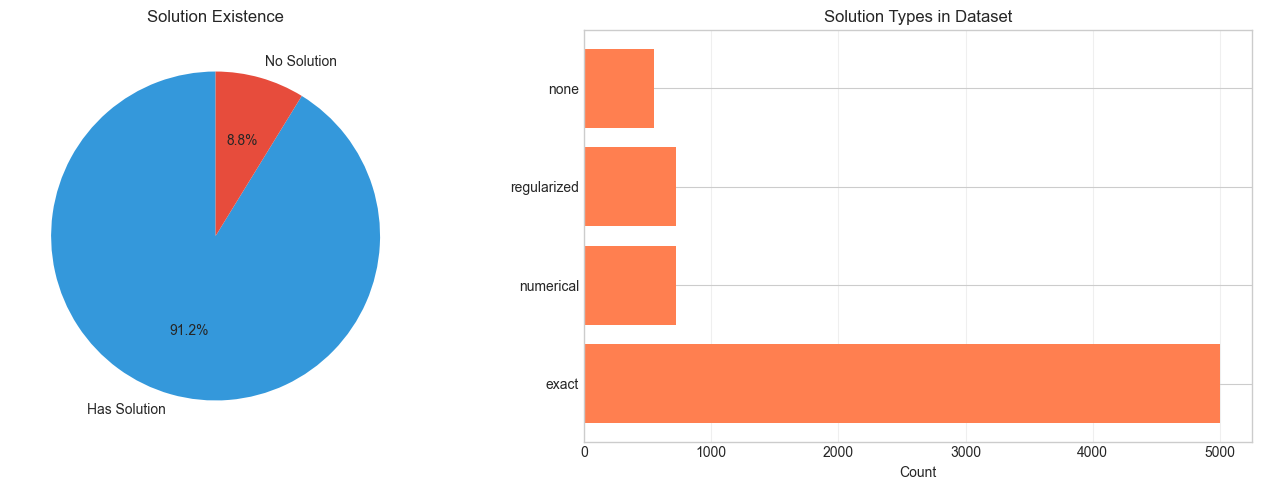

In [22]:
if aug_df is not None:
    # Filter edge cases only
    edge_cases = aug_df[aug_df.get('edge_case', pd.Series([False]*len(aug_df))).notna()]
    
    print(f"📊 Total edge cases: {len(edge_cases):,} ({100*len(edge_cases)/len(aug_df):.1f}% of dataset)\n")
    
    has_solution_counts = aug_df['has_solution'].value_counts()
    solution_type_counts = aug_df['solution_type'].value_counts()
    
    # Tables
    has_solution_df = pd.DataFrame({
        'Has Solution': has_solution_counts.index,
        'Count': has_solution_counts.values,
        'Percentage': [f"{100*c/len(aug_df):.1f}%" for c in has_solution_counts.values]
    })
    display(has_solution_df)
    
    solution_type_df = pd.DataFrame({
        'Solution Type': solution_type_counts.index,
        'Count': solution_type_counts.values,
        'Percentage': [f"{100*c/len(aug_df):.1f}%" for c in solution_type_counts.values]
    })
    display(solution_type_df)
    
    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Has solution pie chart
    axes[0].pie(has_solution_counts.values, labels=[f"{'Has Solution' if k else 'No Solution'}" for k in has_solution_counts.index], 
                autopct='%1.1f%%', colors=['#3498db', '#e74c3c'], startangle=90)
    axes[0].set_title('Solution Existence')
    
    # Solution type bar chart
    axes[1].barh(solution_type_counts.index, solution_type_counts.values, color='coral')
    axes[1].set_xlabel('Count')
    axes[1].set_title('Solution Types in Dataset')
    axes[1].grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

### 7.3 Edge Case Type Breakdown

Deep dive into specific edge case types: no-solution, approximate-only, and ill-posed equations.

,Edge Case Type,Count,Percentage of Edge Cases,Percentage of Total
0,approximate_only,726,36.3%,10.4%
1,ill_posed,723,36.1%,10.3%
2,no_solution,551,27.6%,7.9%



📍 Approximate-Only: 726 equations
   • Method quadrature: 484
   • Method fixed_point_iteration: 242
   • With sample data: 726

📍 Ill-Posed: 723 equations
   • Requires regularization: 723
   • Suggested methods: Tikhonov, Truncated SVD, Landweber iteration

📍 No-Solution: 551 equations
   • Violates Fredholm Alternative - λ is eigenvalue of constant kernel: 242
   • Violates Fredholm Alternative - symmetric kernel with eigenvalue λ=1: 242
   • Violates Fredholm Alternative - λ is eigenvalue of separable kernel: 67



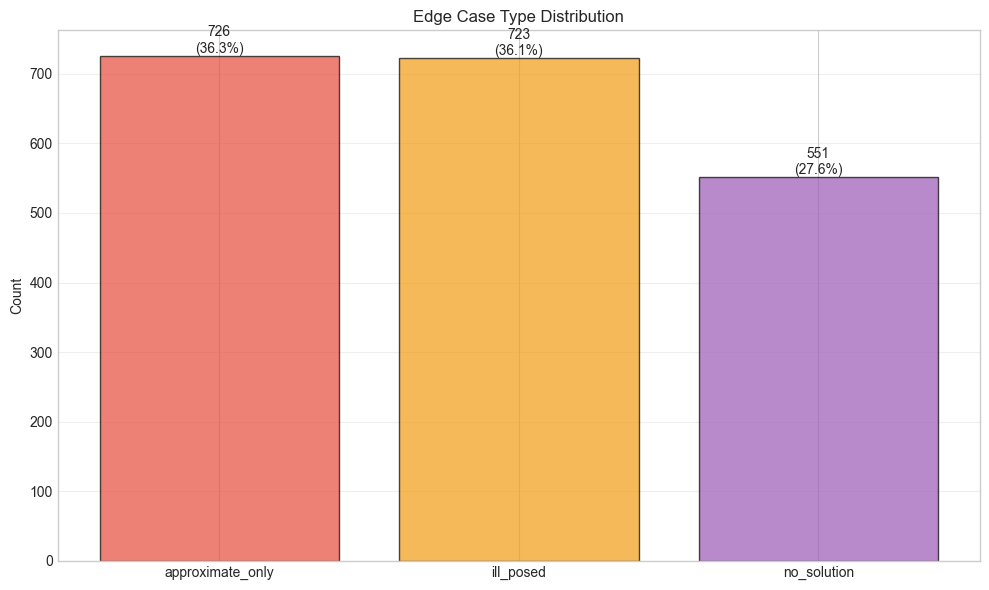

In [23]:
if aug_df is not None and len(edge_cases) > 0:
    # Count each edge case type
    edge_case_types = edge_cases['edge_case'].value_counts()
    
    # Summary table
    edge_type_summary = pd.DataFrame({
        'Edge Case Type': edge_case_types.index,
        'Count': edge_case_types.values,
        'Percentage of Edge Cases': [f"{100*c/len(edge_cases):.1f}%" for c in edge_case_types.values],
        'Percentage of Total': [f"{100*c/len(aug_df):.1f}%" for c in edge_case_types.values]
    })
    display(edge_type_summary)
    
    # Analyze characteristics of each type
    print()
    for edge_type in edge_case_types.index:
        subset = edge_cases[edge_cases['edge_case'] == edge_type]
        print(f"📍 {edge_type.replace('_', '-').title()}: {len(subset):,} equations")
        
        # Show key properties
        if edge_type == 'no_solution':
            if 'reason' in subset.columns:
                reasons = subset['reason'].value_counts()
                for reason, count in reasons.items():
                    print(f"   • {reason}: {count}")
        
        elif edge_type == 'approximate_only':
            if 'numerical_method' in subset.columns:
                methods = subset['numerical_method'].value_counts()
                for method, count in methods.items():
                    print(f"   • Method {method}: {count}")
            if 'sample_points' in subset.columns:
                sample_count = subset['sample_points'].notna().sum()
                print(f"   • With sample data: {sample_count}")
        
        elif edge_type == 'ill_posed':
            if 'requires_regularization' in subset.columns:
                reg_count = subset['requires_regularization'].sum()
                print(f"   • Requires regularization: {reg_count}")
            if 'recommended_methods' in subset.columns:
                example_methods = subset['recommended_methods'].dropna().iloc[0] if len(subset['recommended_methods'].dropna()) > 0 else []
                if example_methods:
                    print(f"   • Suggested methods: {', '.join(example_methods)}")
        print()
    
    # Visualization
    fig, ax = plt.subplots(figsize=(10, 6))
    colors = ['#e74c3c', '#f39c12', '#9b59b6']
    bars = ax.bar(edge_case_types.index, edge_case_types.values, color=colors, alpha=0.7, edgecolor='black')
    ax.set_ylabel('Count')
    ax.set_title('Edge Case Type Distribution')
    ax.grid(axis='y', alpha=0.3)
    
    # Add percentage labels on bars
    for bar, count in zip(bars, edge_case_types.values):
        height = bar.get_height()
        percentage = 100 * count / len(edge_cases)
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{count}\n({percentage:.1f}%)',
                ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

### 7.4 Sample Equations from Each Category

Display example equations from originals and each edge case type.

In [24]:
if aug_df is not None:
    from IPython.display import display, Markdown
    
    # Get samples from each augmentation type
    aug_types = aug_df['augmentation_type'].unique()
    
    for aug_type in sorted(aug_types):
        subset = aug_df[aug_df['augmentation_type'] == aug_type]
        sample = subset.iloc[0] if len(subset) > 0 else None
        
        if sample is not None:
            display(Markdown(f"**{aug_type.replace('_', ' ').title()}** ({len(subset):,} equations)"))
            
            # Display equation
            print(f"u(x) = {sample['u']}")
            print(f"f(x) = {sample['f']}")
            print(f"K(x,t) = {sample['kernel']}")
            print(f"λ = {sample.get('lambda', sample.get('lambda_val', 'N/A'))}, Domain: [{sample['a']}, {sample['b']}]")
            
            # Display metadata
            metadata_parts = []
            metadata_parts.append(f"Solution: {sample.get('solution_type', 'N/A')}")
            
            # Type-specific metadata
            if sample.get('edge_case'):
                if 'reason' in sample and pd.notna(sample['reason']):
                    metadata_parts.append(f"Reason: {sample['reason']}")
                
                if 'numerical_method' in sample and pd.notna(sample['numerical_method']):
                    metadata_parts.append(f"Method: {sample['numerical_method']}")
                
                if 'is_ill_posed' in sample and sample['is_ill_posed']:
                    if 'requires_regularization' in sample and sample['requires_regularization']:
                        metadata_parts.append("Requires regularization")
            
            if metadata_parts:
                print(f"ℹ️ {' | '.join(metadata_parts)}")
            
            print()

**Approximate Only** (726 equations)

u(x) = Numerical
f(x) = 1
K(x,t) = exp(-(x**2 + t**2))
λ = 0.5, Domain: [6.330207264818775, 7.346979435881526]
ℹ️ Solution: numerical | Reason: Gaussian kernel has no symbolic antiderivative | Method: fixed_point_iteration | Requires regularization



**Ill Posed** (723 equations)

u(x) = Requires regularization
f(x) = x**2
K(x,t) = x*t
λ = N/A, Domain: [6.330207264818775, 7.346979435881526]
ℹ️ Solution: regularized | Reason: First kind equation - extremely sensitive to noise in f(x) | Requires regularization



**No Solution** (551 equations)

u(x) = None
f(x) = x
K(x,t) = 1
λ = 0.9835044943792861, Domain: [6.330207264818775, 7.346979435881526]
ℹ️ Solution: none | Reason: Violates Fredholm Alternative - λ is eigenvalue of constant kernel | Requires regularization



**Original** (5,000 equations)

u(x) = x**2
f(x) = x**2 + 67.43530567990815*x - 228.3357446212934
K(x,t) = x - 3.385997028101621
λ = -1.41556822867895, Domain: [6.330207264818775, 7.346979435881526]
ℹ️ Solution: exact | Requires regularization

